<div class="alert alert-block alert-success">
    <h1>DataLab HvA - serie Machine Learning Python - Tech report 7</h1>
</div>

<div class="alert alert-block alert-warning">
    <h2>Regressiebomen</h2>
</div>

### 0. Doel van deze les
Vanwege de serie lessen waarbinnen deze les valt is het hierin de insteek is om het gemaakte model te gaan vergelijken met andere andere Machine Learning modellen en daarbij een kwaliteitscriterium te hanteren waarmee *alle* modellen onderling vergelijkbaar zijn. Dit is de reden dat we werken met een test- en een trainset van onze data.
**Je leert** 
- hoe je in Python met behulp van het package `sklearn` een Beslisboom t.b.v. een Regressietaak kunt maken, ofetwel een Regressieboom
- welke hyperparameters er gekozen kunnen worden om het model te optimaliseren
- hoe je het gevonden model kunt weergeven
- hoe je dit model kunt gebruiken om voorspellingen te genereren op nieuwe data

**Je leert niet:**
- wat de preciese wiskundige definitie en werking van het algoritme is
- hoe je met het package `seaborn` eerste visuele verkenningen van de (variatie in de) data kan uitvoeren, zie hiervoor *Tech report 1: Introductie Machine Learning* uit deze serie.
- hoe je data importeert en inlaadt in de python sessie, zie hiervoor echter wel [deze instructie](https://www.youtube.com/watch?v=1oBVx7pyuXo&list=PLwkTCAI_gJjW10xaAJpdqeQx7EQgFolfG&index=10) 
- wat het preciese concept en DE werking van K-fold crossvalidatie is, zie hiervoor *Tech report 6: K-fold crossvalidatie* uit deze serie.

**Machine Learning framework**
- Om een consistente leerlijn in de serie Machine Learning aan te houden kiezen we telkens voor een opzet waarin een inititeel model bepaald wordt o.b.v. een *deel* van de beschikbare data: de *train data*. Om het model te kunnen vergelijken met ándere modeltypen (waarbij andere algoritmen worden gebruikt) stellen we de voorspellende prestaties vast a.h.v. de nog niet gebruikte data: de *test data*. 

### 1. Laden van de benodigde packages
Packages die je zelf nog niet hebt geinstalleerd dien je vooraf in Python te installeren. 

In [1]:
# Voor de dataset en plots
import matplotlib.pyplot as plt
import seaborn as sns

# Voor het bewerken en inspecteren van de data
import pandas as pd

# Voor het afsplitsen van een train- en test dataset
from sklearn.model_selection import train_test_split

# Voor het modelleren
from sklearn.tree import DecisionTreeRegressor


### 2. Laden en prepareren van de data

We gebruiken als voorbeeld een dataset `'mpg'`. Het betreft data van verschillende kenmerken van verschillende type auto's. Eén van de kenmerken is het brandstogverbruik, uitgedrukt in het aantal *miles per gallon* (`mpg`) dat een auto gemiddeld rijdt. We kunen hierbij indenken dat aantal cilinders (`cylinders`), motorvolume (`displacement`), het continentn waar de auto gefabriceerd is (`origin`) etc. hierop een invloed hebben. Lees bijvoorbeeld wat meer achtergronden hierover [hier](https://www.kaggle.com/datasets/uciml/autompg-dataset). 

#### Laden en weergave data
In deze dataset passen we allereerst ook 2 bewerkingen toe zoals je kunt zien:   
1. We verwijderen een kolom waarin de namen van de auto's genoemd staan. De waarde is hier voor iedere waarneming anders en onbruikbaar op nieuwe data, dus geen verklarende variabele  
2. In de kolom `horsepower` zijn een 6-tal missende waarden aanwezig. Hier kan het model niet mee omgaan. Er zijn diverse manieren om hiermee om te gaan. Eén van de Tech-reports uit deze serie gaat hier dieper op in, zie evt ook [deze informatie](https://scikit-learn.org/stable/modules/impute.html#impute) over de zogenmaade `imputer`. In ons voorbeeld verwijderen we de waarnemingen.

In [2]:
# Laden van een standaard dataset uit package seaborn 
data = sns.load_dataset('mpg')
data = data.drop('name', axis=1) #de naam van de auto zullen we niet als voorspeller in ons model willen, deze verwijderen we.
data = data.dropna() #in `horsepower` zitten een aantal (6) missende waarden - NaN. Hiermee kan een regressieboom niet omgaan
print(data.head())
print(data.shape)
print(data.dtypes)

    mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0    3504          12.0   
1  15.0          8         350.0       165.0    3693          11.5   
2  18.0          8         318.0       150.0    3436          11.0   
3  16.0          8         304.0       150.0    3433          12.0   
4  17.0          8         302.0       140.0    3449          10.5   

   model_year origin  
0          70    usa  
1          70    usa  
2          70    usa  
3          70    usa  
4          70    usa  
(392, 8)
mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight            int64
acceleration    float64
model_year        int64
origin           object
dtype: object


#### One-Hot encoding categoriale variabelen
We zien dat we te maken hebben met een categoriale variabele (`origin`), de regressieboom kan hier niet mee overweg. We maken hiervoor *one-hot encoded variabelen* aan, voor iedere waarde van de categoriale variabelen één (`drop_first=False`) :

In [3]:
data = pd.get_dummies(data=data, drop_first=False)
print(data.head())
print(data.shape)
print(data.dtypes)

    mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0    3504          12.0   
1  15.0          8         350.0       165.0    3693          11.5   
2  18.0          8         318.0       150.0    3436          11.0   
3  16.0          8         304.0       150.0    3433          12.0   
4  17.0          8         302.0       140.0    3449          10.5   

   model_year  origin_europe  origin_japan  origin_usa  
0          70          False         False        True  
1          70          False         False        True  
2          70          False         False        True  
3          70          False         False        True  
4          70          False         False        True  
(392, 10)
mpg              float64
cylinders          int64
displacement     float64
horsepower       float64
weight             int64
acceleration     float64
model_year         int64
origin_europe       bool
origin_japan        bool
or

#### Split variabelen X en y
In dit voorbeeld willen we de waarde voor `mpg` gaan voorspellen, zie ook *sectie 3: Voorbeschouwing* verderop.

In [4]:
#independent variables / explanatory variables
X = data.drop('mpg', axis=1)

#dependent variable / response / target variable.
y = data['mpg']

#### Afsplitsen test data en train data
Voor meer details over deze stap, zie *Tech report 2: Datapreparatie* uit deze serie.

In [5]:
# Split in training en test data 
# random_state kiezen zorgt voor reproduceerbaarheid van dit resultaat - gebruik dat ! Een andere waarde is uiteraard ook prima
# we kiezen voor een verhouden train - test van 75% - 25%. Andere keuzen kunnen ook!
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.25,random_state=999)
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(294, 9)
(98, 9)
(294,)
(98,)


### 3. Voorbeschouwing
Zomaar modelleren doe je niet, eerst moeten we vaststellen wat we willen bereiken of welke vraag we zouden willen beantwoorden. Voor deze les zal dat worden:
- Taak: stel een regressieboom model op om de hoogte van de het brandstofgebruik goed mogelijk te voorspellen op basis van de overige variabelen 

Vanuit de taak zullen we dus stellen:
- De *onafhankelijke* variabelen ($x_i$) zijn de variabelen `cylinders`, `displacement`, `horsepower`, `weight`, `acceleration`, `model_year`, `origin_europe`, `origin_japan`, `origin_usa`
- De *afhankelijke* variabele ($y$) is de variabele `mpg`

We doen dit door per variabele telkens na te gaan hoe er een (nieuwe) 'split' (*vertakking*) in de regressieboom kan worden toegevoegd zodat na een aantal van deze vertakkingen (de *diepte van de boom*) de waarde van `mpg` kan worden voorspeld binnen de grenzen van een zeker interval (de voorspelling zal dan het midden van dat interval geven). Per split, maar ook bij het kiezen van de intervallen waarover de voorspellingen worden verdeeld, wordt er een zogenaamd *informatie criterium* geoptimaliseerd. Het gaat te ver om de details hiervan hier verder te bespreken. Wél kunnen er keuzes gemaakt worden in het trainen van het model die dit proces beïnvloeden. Dit gebeurt in het kiezen van bepaalde *hyper parameters*. Daarover lees je meer verderop.

### 4. Model schatten
#### lees documentatie bij package
Voordat we een model gaan schatten is het van belang dat je de documentatie van het algoritme dat we uit het package gaan gebruiken lezen. In dit geval is dat dus voor `DecisionTreeRegressor()`, die lees je bijvoorbeeld online [hier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn-tree-decisiontreeregressor). Alternatief is om de `help()` functie te gebruiken, zie hieronder. 

In [6]:
# We gaan de methode DecisionTreeRegressor() uit het sklearn package gebruiken, inspecteer hiervoor de documentatie. Dat kan 
help(DecisionTreeRegressor())

Help on DecisionTreeRegressor in module sklearn.tree._classes object:

class DecisionTreeRegressor(sklearn.base.RegressorMixin, BaseDecisionTree)
 |  DecisionTreeRegressor(*, criterion='squared_error', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0, monotonic_cst=None)
 |  
 |  A decision tree regressor.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : {"squared_error", "friedman_mse", "absolute_error",             "poisson"}, default="squared_error"
 |      The function to measure the quality of a split. Supported criteria
 |      are "squared_error" for the mean squared error, which is equal to
 |      variance reduction as feature selection criterion and minimizes the L2
 |      loss using the mean of each terminal node, "friedman_mse", which uses
 |      mean squared error w

Zie bijvoorbeeld de parameters: `criterion`, `max_depth`, en `ccp_alpha`. Ook lees je dat er een *method*  `fit()` voor deze *object class* gedefinieerd is om het model te *fitten*.

#### model fitten
We gebruiken dus de train data om een model te fitten. Dit is, zoals je ziet, een eenvoudig regeltje code. We geven het model een naam (`dtr`) zodat we het later weer opnieuw kunnen aanroepen / gebruiken.

In [7]:
# Met model fitten default van package
dtr = DecisionTreeRegressor(random_state=0)
#Fit the regressor object to the dataset.
dtr.fit(train_X,train_y)

DecisionTreeRegressor(random_state=0)

### 5. Model weergeven
Het weergeven van (kenmerken van) een regressieboom model kan op verschillende manieren. Heel hoog over krijg je een indruk van het aantal vertakkingen (beslisregels die een voor een *split*  zorgen) en de maximale *diepte* van de boom - de lengte van de langste tak:

In [8]:
n_nodes = dtr.tree_.node_count
feature = dtr.tree_.feature
max_depth = dtr.tree_.max_depth
print("Aantal vertakkingen: ", n_nodes )
print("Diepte van de langste tak: ", max_depth)

Aantal vertakkingen:  489
Diepte van de langste tak:  16


Het zou ook kunnen door een lijst te tonen waarin alle beslisregels staan weergegeven. Hierboven zien we al dat dit héél groot is voor dit voorbeeld, we beperken ons dan nu tot een weergave tot maximale diepte 3:

In [9]:
from sklearn.tree import export_text
text_representation = export_text(dtr, max_depth = 3, feature_names = list(train_X))
print(text_representation)

|--- displacement <= 190.50
|   |--- weight <= 2217.00
|   |   |--- model_year <= 77.50
|   |   |   |--- weight <= 2082.50
|   |   |   |   |--- truncated branch of depth 7
|   |   |   |--- weight >  2082.50
|   |   |   |   |--- truncated branch of depth 7
|   |   |--- model_year >  77.50
|   |   |   |--- acceleration <= 20.15
|   |   |   |   |--- truncated branch of depth 13
|   |   |   |--- acceleration >  20.15
|   |   |   |   |--- truncated branch of depth 3
|   |--- weight >  2217.00
|   |   |--- model_year <= 78.50
|   |   |   |--- weight <= 2822.50
|   |   |   |   |--- truncated branch of depth 12
|   |   |   |--- weight >  2822.50
|   |   |   |   |--- truncated branch of depth 6
|   |   |--- model_year >  78.50
|   |   |   |--- displacement <= 137.50
|   |   |   |   |--- truncated branch of depth 8
|   |   |   |--- displacement >  137.50
|   |   |   |   |--- truncated branch of depth 11
|--- displacement >  190.50
|   |--- displacement <= 284.50
|   |   |--- model_year <= 81.50


Iets aanschouwelijker is het om het model te visualiseren in een *boomstructuur*. Ook hier beperken we ons tot de eerste 3 splits per vertakking:

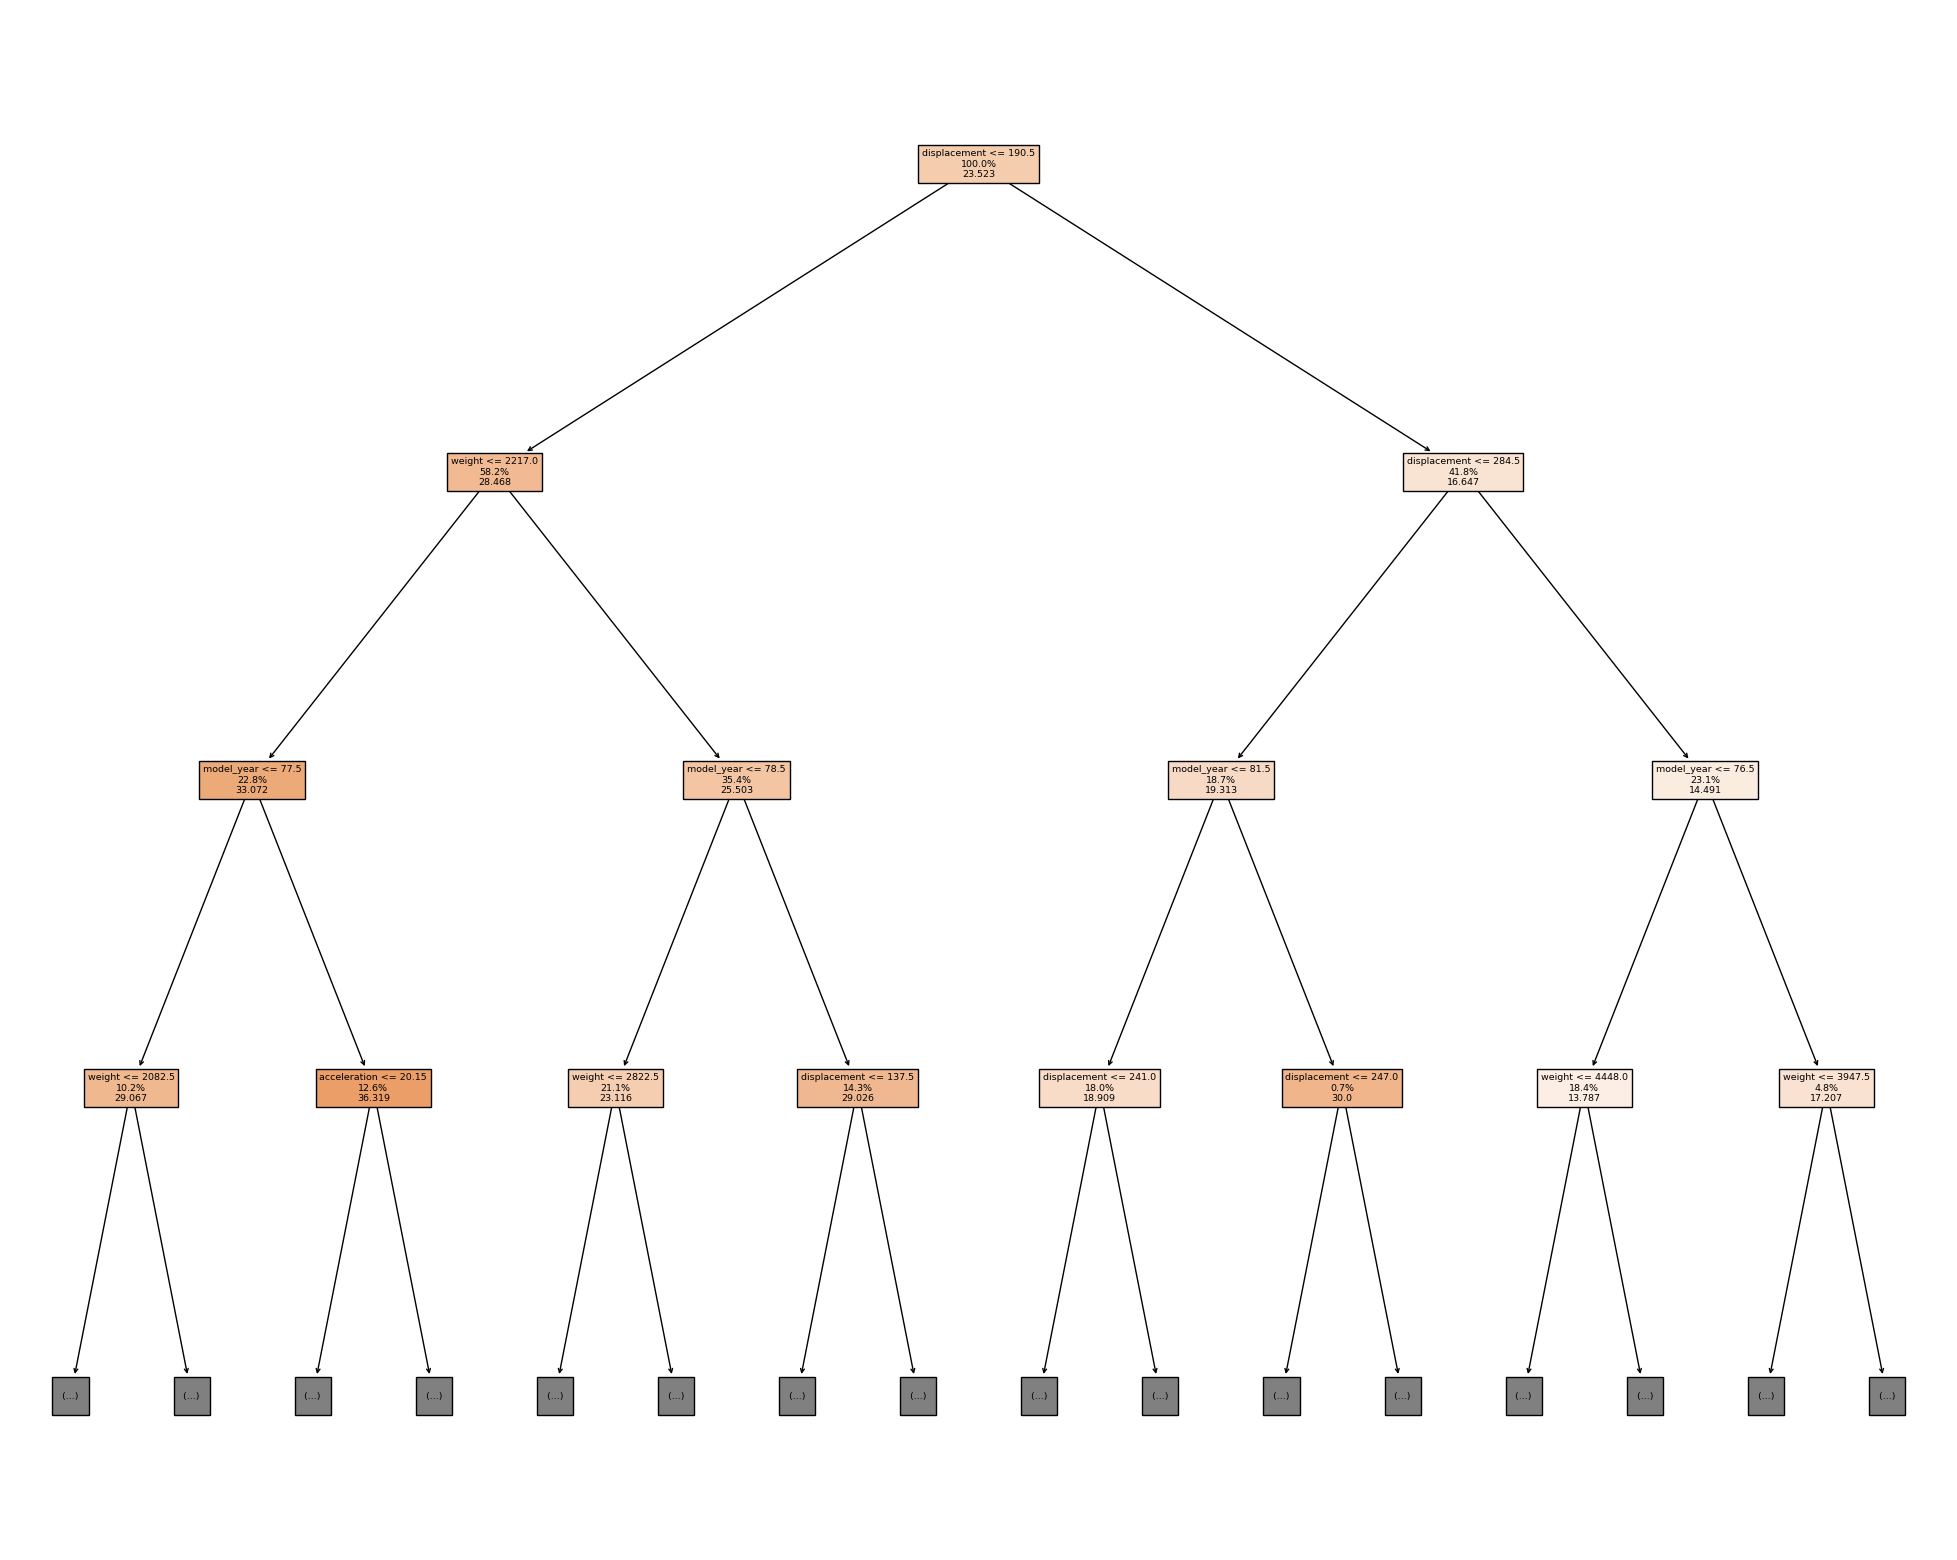

In [10]:
from sklearn.tree import plot_tree
fig = plt.figure(figsize=(25,20))
_ = plot_tree(dtr, max_depth = 3, feature_names = list(train_X), label = 'none', impurity = False, proportion = True, filled=True)


Ten slotte zouden we ons ook kunnen afvragen welke variabelen het sterkste bijdragen aan het verkrijgen van een zo goed mogelijk model? Welke zijn meer bepalend voor de waarde van de voorspelling dan de andere? Dat is vastgelegd in het attribuut `feature_importances_` :

In [11]:
dtr.feature_importances_

array([3.82374777e-03, 6.37128865e-01, 1.14515746e-02, 1.78549364e-01,
       3.18358615e-02, 1.30876717e-01, 5.85424344e-04, 7.03351098e-04,
       5.04509541e-03])

Dit zegt nu nog weinig, maar lees eventueel de uitleg hiervan op [deze pagina](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.base_estimator_). Handiger is het om hier een grafische verwerking van te maken zoals hieronder:

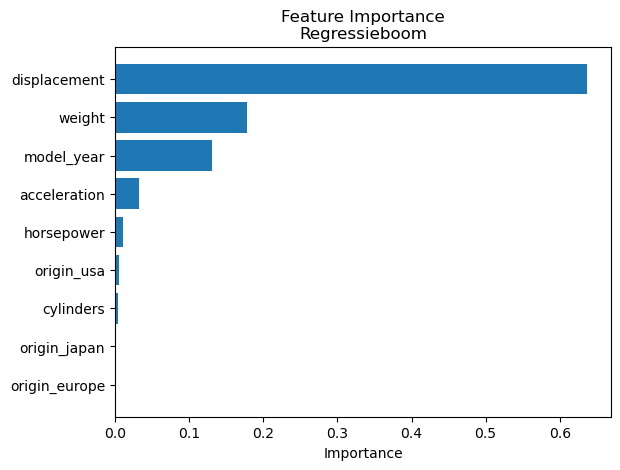

In [12]:
imp_data = pd.DataFrame({'Name':dtr.feature_names_in_, 'Importance':dtr.feature_importances_})
imp_data = imp_data.sort_values(by='Importance', ascending=True)
plt.barh(range(dtr.n_features_in_), imp_data['Importance'])
plt.yticks(range(dtr.n_features_in_),imp_data['Name'].to_numpy())
plt.xlabel('Importance')
plt.title('Feature Importance\nRegressieboom')
plt.show()

We zien dat `displacement`, `weight` en `bouwjaar` de belangrijkste voorspellers zijn voor de waarde `mpg`. Dit komt aardig overeen met onze intuïtie bij dit onderwerp toch?

### 6. Tuning hyperparameters
We hebben onze boom uit het voorbeeld nu zónder enige restrictie gefit. We zien daarbij ook dat het model ogenschijnlijk erg complex is, daarmee lopen we het gevaar dat het model erg overfit is geraakt op de traindata. Met het aantal vertakkingen zoveel groter dan het aantal datapunten in de traindata lijkt dit zeker het geval in ons voorbeeld!

#### modelprestaties op de traindata vs testdata

In [14]:
predicted_y_tr = dtr.predict(train_X)
predicted_y = dtr.predict(test_X)
from sklearn import metrics

#RMSE train
print("DE RMSE op de trainset = ", metrics.root_mean_squared_error(train_y, predicted_y_tr))

#RMSE test
print("DE RMSE op de testset = ", metrics.root_mean_squared_error(test_y, predicted_y))

DE RMSE op de trainset =  0.0
DE RMSE op de testset =  3.0437792030196107


Het model is net zo lang doorgegaan met het maken van vertakkingen tot er geen foute voorspellingen meer waren...er is sprake van een forse overfitting dus, op test presteert het model aanmerkelijk slechter.

#### hyperparameters
Nu gaan we ons bij wijze van voorbeeld richten op een aantal *hyperparameters* die we willen kiezen om dit te voorkomen:  
1. De mate waarin we het kiezen voor meer complixiteit zullen *'afstraffen'* in het proces van het optimaliseren van het informatiecriterium, de *cost complexity parameter*: `ccp_alpha = ...`  (Nb: ook de parameter maximale diepte van ons model: `max_depth = .. .` zouden we kunnen begrenzen om een complexiteit beheersbaar te houden, maak wel een keuze, beide parameters aanpassen is niet handig!)
2. de wijze waarop we het informatie criterium zélf vaststellen: `criterion = ...` een keuze uit `{"squared_error", "friedman_mse", "absolute_error", "poisson"}`

#### Grid search
Hieronder zien we hoe we een *grid*  definieren van modelparameters die we doorlopen en bij elke combinatie wordt een score bepaald o.b.v. een Cross-Validatie ( k = 5) verderop.

Omdat we vooraf geen idee hebben van de waarden die `ccp_alpha` zou moeten doorlopen bestaat er een methode die o.b.v. onze train data kan achterhalen welke waarden van de *cost complexity parameter* zinvol zijn om 'uit te proberen' (in het *grid* op te nemen)

In [30]:
# Bereken de waardes van alpha waar gesplitst wordt
alphas = DecisionTreeRegressor().cost_complexity_pruning_path(train_X,train_y).ccp_alphas
print("Aantal waarden in grid voor ccp:", len(alphas))

Aantal waarden in grid voor ccp: 222


De *duur* van dit proces kan stevig oplopen, ga na dat je 

- voor iedere ( k = ) 5 stappen in de *K-fold Cross Validatie* cf. het voorbeeld hieronder   
- met 4 waarden voor `criterion`, 222 voor `ccp_alpha` al $ 4 \cdot 222  = 888$ modelevaluaties worden bepaald, dat is dus **4440** modelevaluaties!
 

In [20]:
# Hyper parameters range om te doorlopen
# Dit is slechts een voorbeeld, ook de ándere modelparameters kunn hierin worden betrokken

parameters={"criterion" : ["squared_error", "friedman_mse", "absolute_error", "poisson"],
            "ccp_alpha" : alphas               
           }

In [21]:
# Importeer vanuit scikit learn package de tooling:
from sklearn.model_selection import GridSearchCV

We starten hieronder de grid search. We maken een `tuning_model` waarin alle resultaten van de getrainde modellen op alle gridpunten zullen worden bewaard. Zie het *Tech report 6 K-fold crossvalidatie en Grid Search* in deze serie voor meer uitleg en voorbeelden.

Eerst volgt een definitie van de grid search. We zetten (om de output in dit notebook niet te laten exploderen) `verbose = 1`, maar dit kun je zélf eventueel aanpassen.

In [22]:
dtr = DecisionTreeRegressor(random_state=0)
tuning_model = GridSearchCV(estimator = dtr, param_grid = parameters,scoring='neg_mean_squared_error',cv=5,verbose=1)

Hieronder starten we de daarwerkelijke evaluatie, deze stap kan in sommigen gevallen best lang duren!

In [23]:
tuning_model.fit(train_X,train_y)

Fitting 5 folds for each of 888 candidates, totalling 4440 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=0),
             param_grid={'ccp_alpha': array([0.00000000e+00, 1.16006977e-15, 1.54675970e-15, 1.70068027e-05,
       1.70068027e-05, 1.70068027e-05, 2.26757370e-05, 2.26757370e-05,
       6.80272109e-05, 6.80272109e-05, 6.80272109e-05, 6.80272109e-05,
       6.80272109e-05, 1.53061224e-04, 1.53061224e-04, 1.53061224e-04,
       1.53061224e-0...
       1.93677471e-01, 1.94240703e-01, 1.95014245e-01, 2.14887199e-01,
       2.58731553e-01, 2.68089054e-01, 4.31638120e-01, 4.35374150e-01,
       4.42328212e-01, 4.48148148e-01, 6.21477564e-01, 7.56498881e-01,
       8.06312272e-01, 2.40432213e+00, 2.96378468e+00, 2.97470773e+00,
       7.93987830e+00, 3.40043583e+01]),
                         'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error', 'poisson']},
             scoring='neg_mean_squared_error', verbose=1)

Een optimum werd gevonden voor:

In [24]:
print("Beste model: ", tuning_model.best_estimator_)
print("Beste score:  -MSE = ", tuning_model.best_score_)
print("Beste parameter combi: ", tuning_model.best_params_)

Beste model:  DecisionTreeRegressor(ccp_alpha=0.12092404043426258, random_state=0)
Beste score:  -MSE =  -10.691338159059564
Beste parameter combi:  {'ccp_alpha': 0.12092404043426258, 'criterion': 'squared_error'}


Altijd even nagaan of er geen optimum op de rand van de grid werd gevonden: `ccp_alpha': 0.12` is *geen* randpunt van onze range (OK).

### 7. Trainen model met optimale parameterwaarden
We trainen hieronder het model nogmaals, maar dan op de gehele train dataset en mét de gevonden optimale parameterwaarden.

In [25]:
#Definitie
dtr_opt = DecisionTreeRegressor(ccp_alpha=0.121, criterion='squared_error',
                      random_state=0)
#fitten
dtr_opt.fit(train_X,train_y)


DecisionTreeRegressor(ccp_alpha=0.121, random_state=0)

We maken voorspelling op de train data en evalueren deze:

In [27]:
predicted_y_tr = dtr_opt.predict(train_X)
from sklearn import metrics

#RMSE train
print("DE RMSE op de trainset = ", metrics.root_mean_squared_error(train_y, predicted_y_tr))

DE RMSE op de trainset =  1.9577210883226612


### 8. Voorspellingen en performance op testset
Hieronder genereren we voorspellingen van y op de testset. Tevens produceren we een modelscore. Voor meer toelichting daarover verwijzen we naar *Tech report 3: performance metrics regressie en classificatie*.

We zien dat de mate van overfitting vele malen kleiner is, maar de prestatie op test *niet* beter dan bij het *ongelimiteerde zeer complexe model*. Dat kan gebeuren en is bijvoorbeeld een gevolg van de toevallige samenstelling van de *test data*. NB: wat cf. *CRISP-DM* nu **niet** is toegestaan is dat deze observatie je doet besluiten *opnieuw* aan de model architectuur (de hyper  parameters) te tunen! 

In [28]:
predicted_y = dtr_opt.predict(test_X)

#RMSE test
print("DE RMSE op de testset = ", metrics.root_mean_squared_error(test_y, predicted_y))

DE RMSE op de testset =  3.3068237264280693


Voor meer detail van het model zou onderstaande weergave behulpzaam kunnen zijn, naast andere opties die we boven hebben besproken.

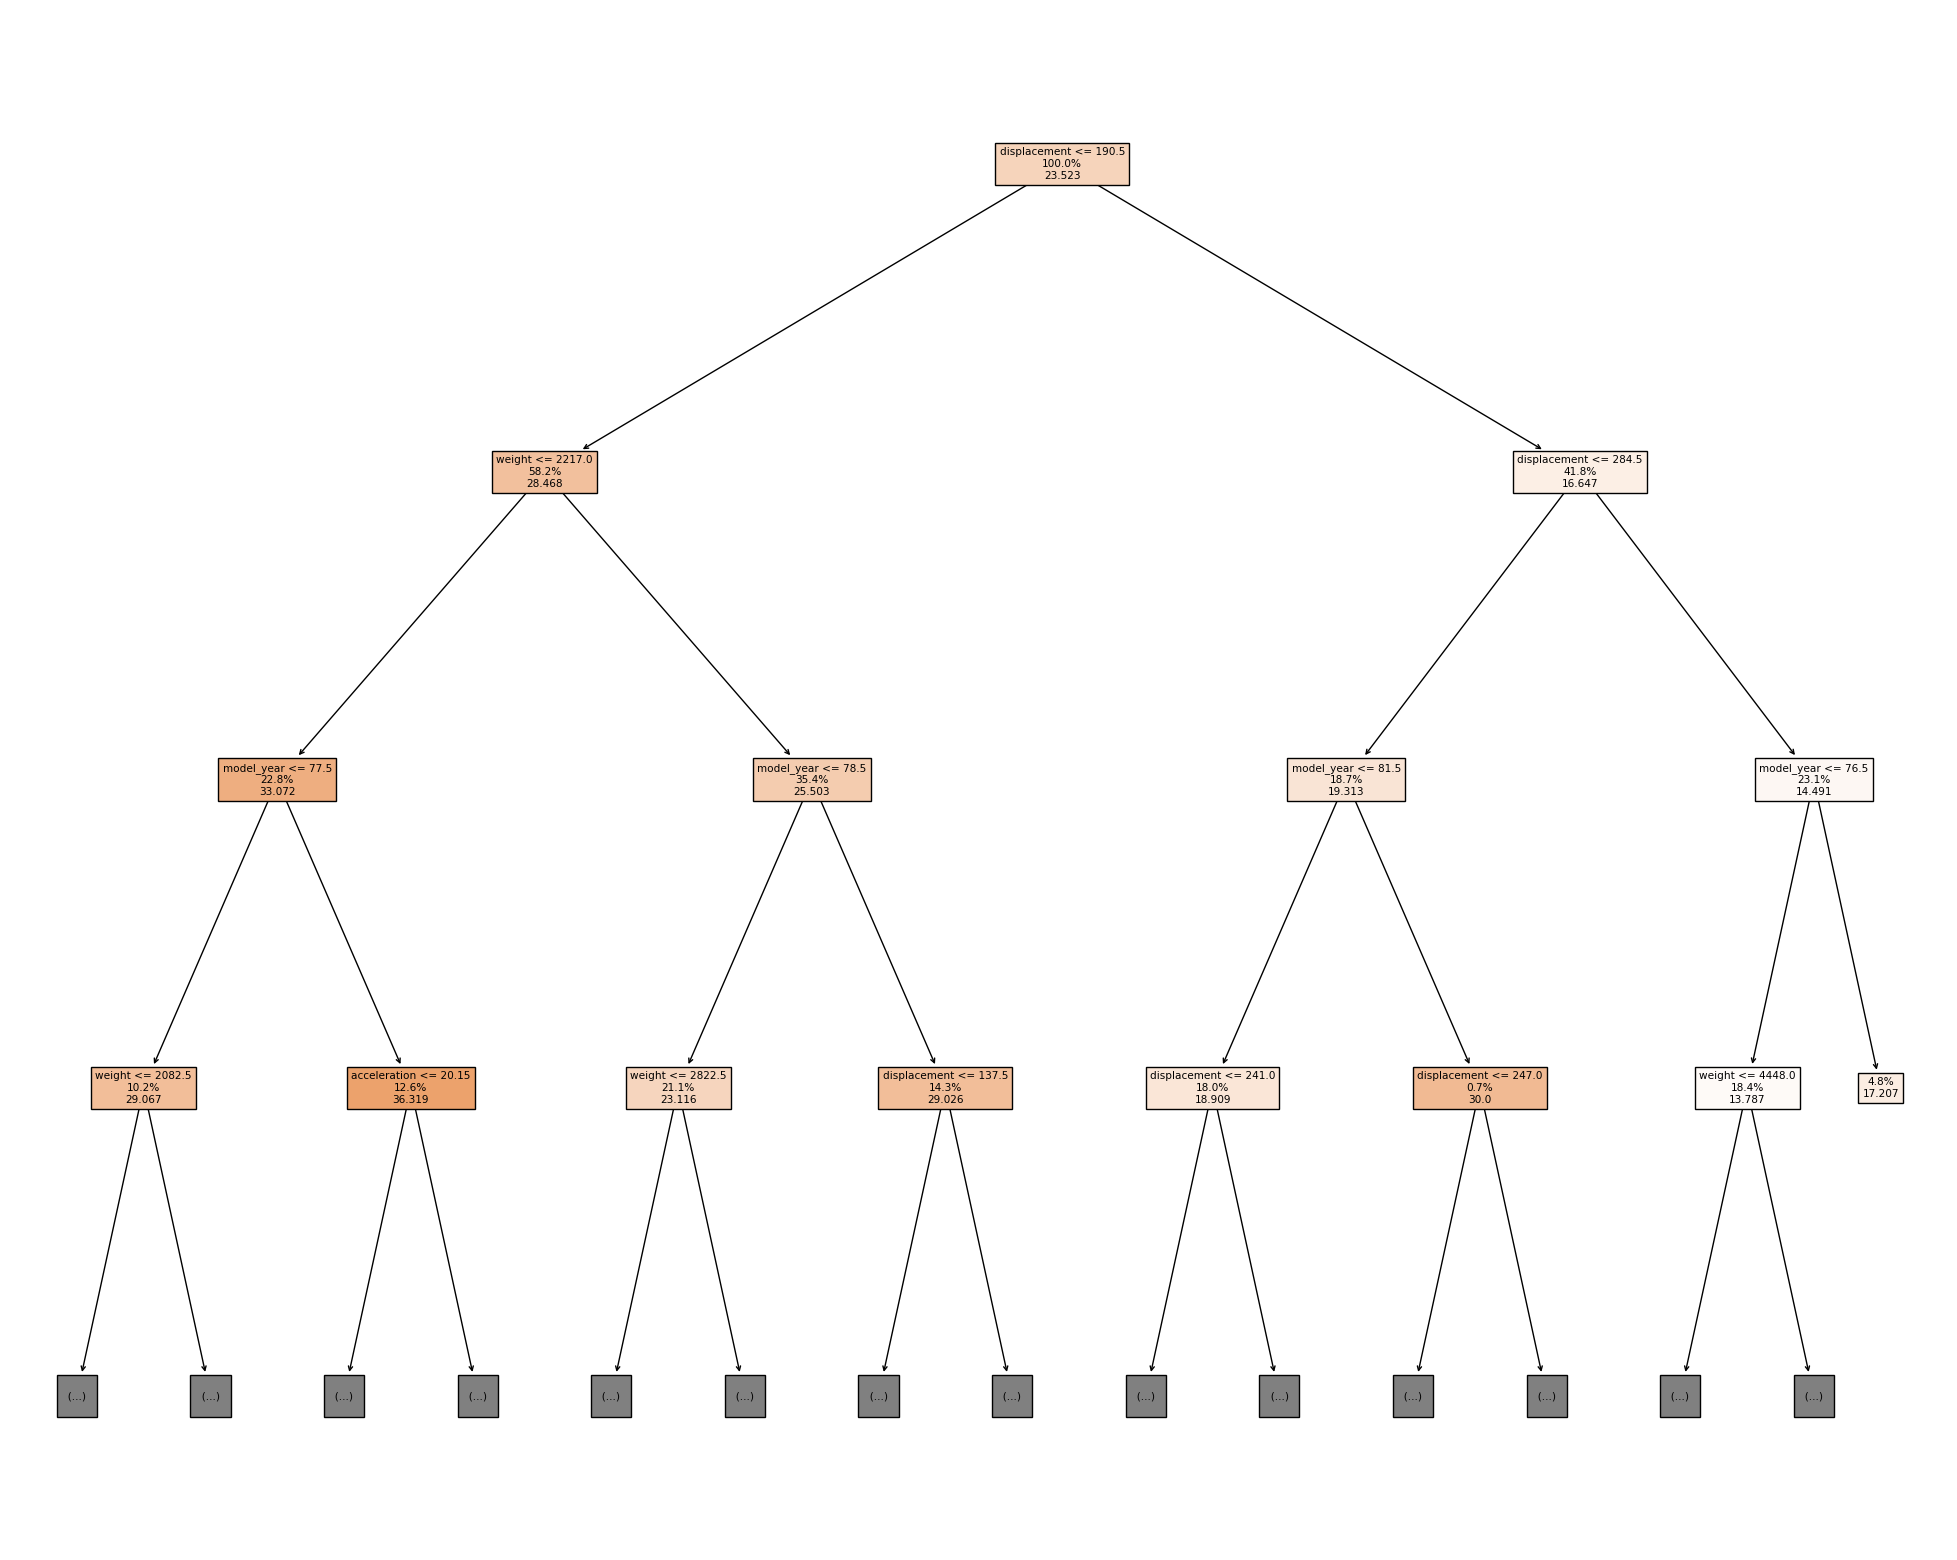

In [29]:
fig = plt.figure(figsize=(25,20))
_ = plot_tree(dtr_opt, max_depth = 3, feature_names = list(train_X), label = 'none', impurity = False, proportion = True, filled=True)
